In [18]:
import pandas as pd
import numpy as np

import os
import json
import nltk
import re
import random

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, RawField, BucketIterator, TabularDataset, Iterator
from torchtext.vocab import Vectors

from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, f1_score
from nltk import word_tokenize
from gensim.models import KeyedVectors

tqdm.pandas()

c:\users\k1l77\python_envs\diploma_env\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
def dump_vocab(vocab, dir_name):
  os.makedirs(dir_name, exist_ok=True)
  with open(os.path.join(dir_name, 'freqs.json'), 'w', encoding='utf-8') as foutp:
    json.dump(vocab.freqs, foutp, ensure_ascii=False, indent=2)
  with open(os.path.join(dir_name, 'itos.json'), 'w', encoding='utf-8') as foutp:
    json.dump(vocab.itos, foutp, ensure_ascii=False, indent=2)
  with open(os.path.join(dir_name, 'stoi.json'), 'w', encoding='utf-8') as foutp:
    json.dump(vocab.stoi, foutp, ensure_ascii=False, indent=2)

def load_vocab(dir_name):
  freqs_path = os.path.join(dir_name, 'freqs.json')
  itos_path = os.path.join(dir_name, 'itos.json')
  stoi_path = os.path.join(dir_name, 'stoi.json')

  with open(freqs_path, 'r', encoding='utf-8') as finp:
    freqs = Counter(json.load(finp))
  with open(itos_path, 'r', encoding='utf-8') as finp:
    itos = json.load(finp)
  with open(stoi_path, 'r', encoding='utf-8') as finp:
    stoi = json.load(finp)
  
  vocab = Vocab(freqs)
  vocab.itos = itos
  vocab.stoi = stoi

  return vocab

In [9]:
%matplotlib inline

In [20]:
def remove_err_span(string):
    match = re.search('<b>.*?</b>', string)
    return string[:match.start()], string[match.end():]

In [21]:
df = pd.read_excel("Prepositions1.xlsx")

In [22]:
df.head()

,id,Sentence,Right answer,Error type,Wrong answer,Contains prep
0,34,Considerable social and financial resources a...,to,Prepositions,on,True
1,56,5) No sooner had Alex knocked <b>the door</b>...,at the door,Prepositions,the door,True
2,63,"For example, Russian company “Aeroflot” under...",per,Prepositions,in,True
3,65,There is the map of current flights <b>on</b>...,in,Prepositions,on,True
4,81,The given bar chart compares data <b>on</b> ac...,about,Prepositions,on,True


In [23]:
df.shape

(8585, 6)

In [24]:
n_words = lambda x: len(word_tokenize(x))

In [25]:
df['Right answer'] = df['Right answer'].apply(lambda x: x.lower())
df['Wrong answer'] = df['Wrong answer'].apply(lambda x: x.lower())

df['N words right'] = df['Right answer'].apply(n_words)
df['N words wrong'] = df['Wrong answer'].apply(n_words)

In [26]:
df1 = df[(df['N words wrong'] == df['N words right']) & (df['N words wrong'] == 1)]
bad_df = df[(df['N words wrong'] != df['N words right']) | (df['N words wrong'] != 1)]
bad_df.to_excel("N words prepositions.xlsx")

In [27]:
df1['Wrong answer'].value_counts()/df1.shape[0]

in            0.192965
on            0.142304
for           0.139561
of            0.110197
to            0.091642
                ...   
because       0.000161
quite         0.000161
concerning    0.000161
t             0.000161
due           0.000161
Name: Wrong answer, Length: 103, dtype: float64

In [28]:
df1.shape

(6198, 8)

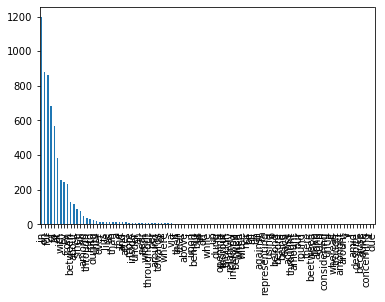

In [29]:
df1['Wrong answer'].value_counts().plot.bar()

In [30]:
df1['Wrong answer'].value_counts().quantile(0.95)

370.0999999999989

In [31]:
df1['Wrong answer'].value_counts().quantile(0.8)

13.600000000000009

In [32]:
df1['Wrong answer'].value_counts()[:20].sum()

5904

In [33]:
df1 = df1.set_index('id')

In [34]:
df1 = df1.drop(['Error type','Contains prep','N words right','N words wrong'], axis=1)

In [35]:
crosstab = pd.crosstab(df1['Right answer'], df1['Wrong answer'])

In [36]:
crosstab

Wrong answer,"""",",",-,:,a,about,above,across,after,against,...,using,via,when,where,whereas,while,with,withe,within,y
Right answer,,,,,,,,,,,,,,,,,,,,,
by,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
in,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
of,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
with,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
while,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,0,0
with,1,0,0,0,0,3,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0
within,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [37]:
crosstab.to_excel('preposition_crosstab.xlsx')

In [38]:
df1[['Left','Right']] = df1.apply(lambda x: remove_err_span(x['Sentence']),
                              axis=1, result_type="expand")
df1 = df1.drop(['Sentence'], axis=1)

In [39]:
df1.head()

,Right answer,Wrong answer,Left,Right
id,,,,
34,to,on,Considerable social and financial resources a...,solving this problem.
63,per,in,"For example, Russian company “Aeroflot” under...","day and, according to the interview of stuff,..."
65,in,on,There is the map of current flights,the Internet and it can be seen from it that ...
81,about,on,The given bar chart compares data,access to primary education for boys and girl...
120,with,of,This difference estimates 10 million in compa...,the same indicators in Africa in 2012.


In [40]:
df1 = df1[['Left','Right','Wrong answer','Right answer']]

In [41]:
df1.head()

,Left,Right,Wrong answer,Right answer
id,,,,
34,Considerable social and financial resources a...,solving this problem.,on,to
63,"For example, Russian company “Aeroflot” under...","day and, according to the interview of stuff,...",in,per
65,There is the map of current flights,the Internet and it can be seen from it that ...,on,in
81,The given bar chart compares data,access to primary education for boys and girl...,on,about
120,This difference estimates 10 million in compa...,the same indicators in Africa in 2012.,of,with


In [42]:
df1.shape

(6198, 4)

In [43]:
df1['Rare'] = df1['Wrong answer'].apply(lambda x: df1['Wrong answer'].value_counts()[x] < 4)

In [44]:
df1 = df1[df1['Rare'] == False]

In [45]:
df1['Wrong answer'].unique()

array(['on', 'in', 'of', 'from', 'for', 'till', 'with', 'through', 'by',
       'since', 'into', 'to', 'among', 'at', 'between', 'like', 'until',
       'that', 'about', 'or', 'and', 'towards', 'is', 'over', 'after',
       'during', 'where', 'above', 'near', 'the', 'a', 'as', 'an', 'if',
       'under', 'inside', 'per', 'within', 'then', 'than', 'throughout',
       'around', 'via', 'i', '-', 'more'], dtype=object)

In [46]:
preps = df1['Wrong answer'].unique()

In [47]:
df1.to_csv("Preposition_dataset_long.csv")

In [48]:
df1.to_excel("Preposition_dataset_long.xlsx")

In [44]:
'of' in model.wv

c:\users\k1l77\python_envs\torch_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


False

## Работа с датасетом:

In [3]:
from classifier import *

vectors = Vectors('gensim_models/WebVectores 12/model.txt')

In [4]:
TOKENS = Field(lower=True, tokenize=nltk.word_tokenize)
ANSWER = LabelField(dtype=tt.int64, use_vocab=True, unk_token='<unk>')
ID = RawField()

In [5]:
lexics_dataset = TabularDataset("Preposition_dataset_long.csv", format='csv',
                                fields=[('context_id',ID), ('left',TOKENS), ('right', TOKENS),
                                        ('wrong_item',ANSWER), ('right_item',ANSWER)],
                                skip_header=True)

In [7]:
random.seed(42)
train_set, valid_set = lexics_dataset.split(0.8, random_state=random.getstate())
TOKENS.build_vocab(train_set)
ANSWER.build_vocab(train_set, valid_set)

unk_answer_id = len(ANSWER.vocab.itos)
ANSWER.vocab.itos.append('<unk>')
ANSWER.vocab.stoi['<unk>'] = unk_answer_id
ANSWER.vocab.freqs['<unk>'] = 0

In [8]:
len(ANSWER.vocab.itos)

69

In [9]:
class W2VErrorModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden1_size, hidden2_size, output_size, #vectors,
                 dropout1_rate=0.05, dropout2_rate=0.1, dropout3_rate=0.2, activation=nn.ReLU()):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)#.from_pretrained(vectors, freeze=False)
        self.frozen_embedding = nn.Embedding(output_size, embed_size)#.from_pretrained(vectors, freeze=False)
        
        self.dropout1 = nn.Dropout(p=dropout1_rate)
        
        self.lstm1 = nn.LSTM(input_size=embed_size,
                             hidden_size=hidden1_size,
                             batch_first=False,
                             bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=embed_size,
                             hidden_size=hidden1_size,
                             batch_first=False,
                             bidirectional=False)
        
        self.dropout2 = nn.Dropout(p=dropout2_rate)
        self.fc1 = nn.Linear(hidden1_size*2+embed_size, hidden2_size)
        self.activation = activation
        self.dropout3 = nn.Dropout(p=dropout3_rate)
        self.fc2 = nn.Linear(hidden2_size, output_size)
    
    def forward(self, batch):
        ## Run forward-LSTM on left context of error:
        left = self.embedding(batch.left)
        left = self.dropout1(left)
        left, _ = self.lstm1(left)
        left = left[-1]
        
        ## Run backward-LSTM on Left context of error:
        right = self.embedding(batch.right)
        right = self.dropout1(right)
        right, _ = self.lstm2(right)
        right = right[-1]
        
        correction = self.frozen_embedding(batch.right_item)
        
        ## Concatenate:
        x = tt.cat([left,right,correction],dim=1)
        x = self.dropout2(x)
        
        ## Apply fully connected layers:
        x = self.dropout3(self.activation(self.fc1(x)))
        x = self.fc2(x)
        return x

In [10]:
def calculate_accuracy_and_f1(true, pred):
    pred = pred.data.cpu()
    true = true.data.cpu()
    accuracy = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average='weighted')
    return accuracy, f1

def invert_seq_batch(batch):
    ## Solution from https://discuss.pytorch.org/t/how-to-use-a-lstm-in-a-reversed-direction/14389
    inv_idx = tt.arange(batch.size(1)-1, -1, -1).long()
    return batch.index_select(1, inv_idx)


class Batch:
    def __init__(self, batch, device):
        self.left = batch.left.to(device)
        self.right = invert_seq_batch(batch.right).to(device)
        self.wrong_item = batch.wrong_item.to(device)
        self.right_item = batch.right_item.to(device)

In [11]:
def train(model, train_iterator, optimizer, criterion, device,
          scheduler, n_epochs, penalty_multiplier=1.1):
    
    for epoch in range(n_epochs):
        train_loss, train_acc, train_f1 = train_epoch(model, train_iterator, optimizer, criterion, device, epoch,
                                                     penalty_multiplier)
        if scheduler:
            scheduler.step(train_loss)
        print(f"Training loss: {round(train_loss,5)} accuracy: {round(train_acc,4)} f1: {round(train_f1,4)}")

def train_epoch(model, train_iterator, optimizer, criterion, device, n_epoch,
                penalty_multiplier=1):
    losses = []
    model.train()
    n_batches = len(train_iterator)
    iterator = tqdm_notebook(train_iterator, total=n_batches, desc=f"Training epoch {n_epoch}", leave=True)
    
    for i, batch in enumerate(iterator):
        optimizer.zero_grad()
        
        batch = Batch(batch, device)
        pred = model(batch)
        ## Criterion should have param "reduce" set to None
        loss = criterion(pred, batch.wrong_item)
        
        if penalty_multiplier != 1:
            ## check if predicted value equals right tense:
            pen_vec = pred.argmax(dim=1) == batch.right_item
            ## form penalty vector:
            penalty_multiplier = tt.Tensor([penalty_multiplier]).to(device)
            pen_vec = pen_vec.type(tt.float).to(device)
            pen_vec = (pen_vec+1)**tt.log2(penalty_multiplier)
            ## punish if it equals:
            loss = loss * pen_vec
        loss = loss.mean()
        loss.backward()
        optimizer.step()
        
        curr_loss = loss.data.cpu().detach().item()
        iterator.set_postfix(loss=str(round(curr_loss,5)))
        acc, f1 = calculate_accuracy_and_f1(batch.wrong_item, pred.argmax(dim=1))
        losses.append((curr_loss, acc, f1))
    return np.mean(losses, axis=0)

def get_k_predicted_items(model, iterator, device, inv_labels, k=4):
    output = []
    model.eval()
    n_batches = len(iterator)
    batch_iter = tqdm_notebook(iterator, total=n_batches)
    with tt.no_grad():
        for batch in batch_iter:
            batch_gpu = Batch(batch, device)
            pred = F.softmax(model(batch_gpu).data.cpu())
            top_k = pred.topk(k=k, dim=1)
            top_probas, top_ids = top_k.values, top_k.indices
            tenses = [[inv_labels[int(i)] for i in text] for text in top_ids]
            output.append((batch.context_id, tenses, top_probas))
    return output

In [12]:
device = tt.device('cuda')

tt.cuda.empty_cache()

batch_size = 256

train_iter, val_iter = BucketIterator.splits((train_set, valid_set),
                                                             batch_sizes=(batch_size,batch_size,batch_size),
                                                             shuffle=False, sort_key=lambda x:len(x.left)+len(x.right))

model = W2VErrorModel(vocab_size=len(TOKENS.vocab.itos),embed_size=300,
                hidden1_size=200, hidden2_size=150, output_size=len(ANSWER.vocab.itos))
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss().to(device)
scheduler = tt.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)

In [13]:
history = train(model, train_iter, optimizer, criterion, device, scheduler, n_epochs=500, penalty_multiplier=2)

c:\users\k1l77\python_envs\torch_env\lib\site-packages\ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


c:\users\k1l77\python_envs\torch_env\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\k1l77\python_envs\torch_env\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Training loss: 3.95847 accuracy: 0.1791 f1: 0.0988



Training loss: 3.39012 accuracy: 0.2254 f1: 0.1036



Training loss: 2.68194 accuracy: 0.242 f1: 0.1508



Training loss: 2.4805 accuracy: 0.2489 f1: 0.1928



Training loss: 2.40676 accuracy: 0.2663 f1: 0.2132



Training loss: 2.36471 accuracy: 0.2643 f1: 0.2182



Training loss: 2.34526 accuracy: 0.2721 f1: 0.2275



Training loss: 2.31467 accuracy: 0.2799 f1: 0.2337



Training loss: 2.30089 accuracy: 0.2788 f1: 0.2339



Training loss: 2.28577 accuracy: 0.2792 f1: 0.2348



Training loss: 2.26198 accuracy: 0.2882 f1: 0.2428



Training loss: 2.25477 accuracy: 0.2792 f1: 0.2378



Training loss: 2.25401 accuracy: 0.2832 f1: 0.2418



Training loss: 2.23325 accuracy: 0.2891 f1: 0.2451



Training loss: 2.23369 accuracy: 0.2813 f1: 0.2428



Training loss: 2.21736 accuracy: 0.2997 f1: 0.2591



Training loss: 2.21682 accuracy: 0.2909 f1: 0.2511



Training loss: 2.21424 accuracy: 0.2889 f1: 0.2483



Training loss: 2.19413 accuracy: 0.2907 f1: 0.2509



Training loss: 2.19688 accuracy: 0.3024 f1: 0.2666



Training loss: 2.18798 accuracy: 0.2913 f1: 0.2528



Training loss: 2.18139 accuracy: 0.2924 f1: 0.2537



Training loss: 2.19181 accuracy: 0.2956 f1: 0.2572



Training loss: 2.17206 accuracy: 0.3032 f1: 0.2644



Training loss: 2.17542 accuracy: 0.2899 f1: 0.2539



Training loss: 2.15839 accuracy: 0.3018 f1: 0.2681



Training loss: 2.15898 accuracy: 0.2999 f1: 0.2632



Training loss: 2.15066 accuracy: 0.2977 f1: 0.262



Training loss: 2.14461 accuracy: 0.3003 f1: 0.2647



Training loss: 2.1427 accuracy: 0.3036 f1: 0.2671



Training loss: 2.14959 accuracy: 0.2985 f1: 0.2611



Training loss: 2.14343 accuracy: 0.296 f1: 0.2618



Training loss: 2.13275 accuracy: 0.2926 f1: 0.2589



Training loss: 2.12598 accuracy: 0.3026 f1: 0.268



Training loss: 2.13758 accuracy: 0.3032 f1: 0.2691



Training loss: 2.12547 accuracy: 0.3053 f1: 0.2707



Training loss: 2.11926 accuracy: 0.3067 f1: 0.2725



Training loss: 2.11431 accuracy: 0.3048 f1: 0.2707



Training loss: 2.12092 accuracy: 0.3065 f1: 0.2731



Training loss: 2.12083 accuracy: 0.2989 f1: 0.2646



Training loss: 2.11498 accuracy: 0.3016 f1: 0.2669



Training loss: 2.10737 accuracy: 0.3081 f1: 0.2744



Training loss: 2.11045 accuracy: 0.3091 f1: 0.2751



Training loss: 2.09631 accuracy: 0.3134 f1: 0.2775



Training loss: 2.10119 accuracy: 0.3114 f1: 0.2762



Training loss: 2.1064 accuracy: 0.3124 f1: 0.2771



Training loss: 2.09458 accuracy: 0.3071 f1: 0.2742



Training loss: 2.09952 accuracy: 0.3116 f1: 0.2792



Training loss: 2.09009 accuracy: 0.3112 f1: 0.2767



Training loss: 2.09127 accuracy: 0.3124 f1: 0.2786



Training loss: 2.08876 accuracy: 0.3012 f1: 0.2684



Training loss: 2.0848 accuracy: 0.3081 f1: 0.2761



Training loss: 2.08442 accuracy: 0.3065 f1: 0.2719



Training loss: 2.09139 accuracy: 0.3092 f1: 0.2754



Training loss: 2.08827 accuracy: 0.3063 f1: 0.2766



Training loss: 2.07607 accuracy: 0.3147 f1: 0.2785



Training loss: 2.0726 accuracy: 0.3095 f1: 0.2764



Training loss: 2.0665 accuracy: 0.3182 f1: 0.2795



Training loss: 2.07567 accuracy: 0.311 f1: 0.2776



Training loss: 2.06224 accuracy: 0.3196 f1: 0.286



Training loss: 2.05494 accuracy: 0.3208 f1: 0.2861



Training loss: 2.0588 accuracy: 0.3225 f1: 0.28



Training loss: 2.07615 accuracy: 0.311 f1: 0.2771



Training loss: 2.05499 accuracy: 0.3264 f1: 0.2879



Training loss: 2.04795 accuracy: 0.3251 f1: 0.2879



Training loss: 2.03762 accuracy: 0.3272 f1: 0.2878



Training loss: 2.0348 accuracy: 0.3331 f1: 0.2951



Training loss: 2.01151 accuracy: 0.3395 f1: 0.3011



Training loss: 2.00662 accuracy: 0.3505 f1: 0.3079



Training loss: 1.99481 accuracy: 0.3534 f1: 0.3099



Training loss: 1.95462 accuracy: 0.3702 f1: 0.3291



Training loss: 1.96317 accuracy: 0.3688 f1: 0.3281



Training loss: 1.94151 accuracy: 0.3712 f1: 0.3321



Training loss: 1.92378 accuracy: 0.3817 f1: 0.339



Training loss: 1.90069 accuracy: 0.3972 f1: 0.3557



Training loss: 1.89378 accuracy: 0.3999 f1: 0.3571



Training loss: 1.89268 accuracy: 0.3974 f1: 0.3561



Training loss: 1.90137 accuracy: 0.3874 f1: 0.3415



Training loss: 1.85884 accuracy: 0.4075 f1: 0.3658



Training loss: 1.85395 accuracy: 0.4095 f1: 0.3654



Training loss: 1.86595 accuracy: 0.4132 f1: 0.3704



Training loss: 1.83494 accuracy: 0.406 f1: 0.3637



Training loss: 1.81732 accuracy: 0.4147 f1: 0.3716



Training loss: 1.80887 accuracy: 0.4308 f1: 0.3894



Training loss: 1.78815 accuracy: 0.4268 f1: 0.3844



Training loss: 1.78292 accuracy: 0.4298 f1: 0.3906



Training loss: 1.76743 accuracy: 0.438 f1: 0.398



Training loss: 1.73824 accuracy: 0.4589 f1: 0.4198



Training loss: 1.71226 accuracy: 0.4722 f1: 0.4322



Training loss: 1.7046 accuracy: 0.4611 f1: 0.4195



Training loss: 1.71829 accuracy: 0.456 f1: 0.416



Training loss: 1.68891 accuracy: 0.4693 f1: 0.4266



Training loss: 1.68185 accuracy: 0.4663 f1: 0.4249



Training loss: 1.66688 accuracy: 0.4812 f1: 0.4403



Training loss: 1.63059 accuracy: 0.4976 f1: 0.4599



Training loss: 1.61404 accuracy: 0.5119 f1: 0.4765



Training loss: 1.61283 accuracy: 0.4988 f1: 0.4597



Training loss: 1.59892 accuracy: 0.5125 f1: 0.4745



Training loss: 1.57302 accuracy: 0.517 f1: 0.4828



Training loss: 1.56354 accuracy: 0.5183 f1: 0.4812



Training loss: 1.58631 accuracy: 0.5152 f1: 0.4785



Training loss: 1.59247 accuracy: 0.5037 f1: 0.4678



Training loss: 1.56628 accuracy: 0.5181 f1: 0.4844



Training loss: 1.51651 accuracy: 0.5437 f1: 0.5087



Training loss: 1.49154 accuracy: 0.5601 f1: 0.5257



Training loss: 1.5186 accuracy: 0.5376 f1: 0.504



Training loss: 1.4716 accuracy: 0.555 f1: 0.5177



Training loss: 1.42703 accuracy: 0.5773 f1: 0.5419



Training loss: 1.41773 accuracy: 0.5736 f1: 0.541



Training loss: 1.39484 accuracy: 0.5789 f1: 0.5446



Training loss: 1.37429 accuracy: 0.5896 f1: 0.5552



Training loss: 1.36227 accuracy: 0.5947 f1: 0.5623



Training loss: 1.34933 accuracy: 0.5996 f1: 0.5694



Training loss: 1.36948 accuracy: 0.5927 f1: 0.5639



Training loss: 1.32578 accuracy: 0.605 f1: 0.5746



Training loss: 1.2814 accuracy: 0.6219 f1: 0.5938



Training loss: 1.27636 accuracy: 0.6277 f1: 0.5968



Training loss: 1.25093 accuracy: 0.6326 f1: 0.6046



Training loss: 1.22457 accuracy: 0.6369 f1: 0.6087



Training loss: 1.22519 accuracy: 0.6381 f1: 0.612



Training loss: 1.20009 accuracy: 0.6433 f1: 0.6183



Training loss: 1.1809 accuracy: 0.6465 f1: 0.6194



Training loss: 1.15199 accuracy: 0.6558 f1: 0.6288



Training loss: 1.15007 accuracy: 0.6615 f1: 0.6355



Training loss: 1.13967 accuracy: 0.665 f1: 0.6398



Training loss: 1.13913 accuracy: 0.6619 f1: 0.6364



Training loss: 1.12173 accuracy: 0.6615 f1: 0.6357



Training loss: 1.10727 accuracy: 0.676 f1: 0.6526



Training loss: 1.08894 accuracy: 0.676 f1: 0.6533



Training loss: 1.07768 accuracy: 0.6801 f1: 0.6565



Training loss: 1.0758 accuracy: 0.6738 f1: 0.6514



Training loss: 1.06794 accuracy: 0.6822 f1: 0.6591



Training loss: 1.0351 accuracy: 0.6955 f1: 0.6735



Training loss: 1.02025 accuracy: 0.7 f1: 0.6792



Training loss: 0.99186 accuracy: 0.7072 f1: 0.6867



Training loss: 0.9807 accuracy: 0.7107 f1: 0.6906



Training loss: 0.97794 accuracy: 0.7121 f1: 0.6913



Training loss: 0.97224 accuracy: 0.716 f1: 0.6942



Training loss: 0.96046 accuracy: 0.7103 f1: 0.6889



Training loss: 0.96349 accuracy: 0.7188 f1: 0.6982



Training loss: 0.95435 accuracy: 0.7211 f1: 0.7022



Training loss: 0.9179 accuracy: 0.7338 f1: 0.7127



Training loss: 0.90773 accuracy: 0.7346 f1: 0.7162



Training loss: 0.89396 accuracy: 0.7371 f1: 0.7186



Training loss: 0.87886 accuracy: 0.7406 f1: 0.7198



Training loss: 0.86159 accuracy: 0.7467 f1: 0.7275



Training loss: 0.84714 accuracy: 0.7562 f1: 0.7383



Training loss: 0.83578 accuracy: 0.7506 f1: 0.7336



Training loss: 0.83797 accuracy: 0.7555 f1: 0.7392



Training loss: 0.85266 accuracy: 0.7582 f1: 0.743



Training loss: 0.84035 accuracy: 0.7578 f1: 0.741



Training loss: 0.80029 accuracy: 0.7676 f1: 0.7503



Training loss: 0.79762 accuracy: 0.7683 f1: 0.7521



Training loss: 0.80293 accuracy: 0.7666 f1: 0.7501



Training loss: 0.80197 accuracy: 0.7637 f1: 0.7469



Training loss: 0.79026 accuracy: 0.7682 f1: 0.7531



Training loss: 0.7634 accuracy: 0.7734 f1: 0.756



Training loss: 0.73899 accuracy: 0.7834 f1: 0.7665



Training loss: 0.75277 accuracy: 0.783 f1: 0.7678



Training loss: 0.77568 accuracy: 0.7736 f1: 0.7607



Training loss: 0.75821 accuracy: 0.7785 f1: 0.7622



Training loss: 0.77576 accuracy: 0.7719 f1: 0.7585



Training loss: 0.79188 accuracy: 0.7689 f1: 0.7542



Training loss: 0.77881 accuracy: 0.7682 f1: 0.7535



Training loss: 0.77208 accuracy: 0.7689 f1: 0.7543



Training loss: 0.72083 accuracy: 0.7854 f1: 0.7703



Training loss: 0.70278 accuracy: 0.7941 f1: 0.779



Training loss: 0.68858 accuracy: 0.7998 f1: 0.7862



Training loss: 0.68634 accuracy: 0.8004 f1: 0.7867



Training loss: 0.65594 accuracy: 0.8092 f1: 0.7961



Training loss: 0.66222 accuracy: 0.8092 f1: 0.7957



Training loss: 0.65506 accuracy: 0.8117 f1: 0.7982



Training loss: 0.64424 accuracy: 0.8098 f1: 0.7968



Training loss: 0.62419 accuracy: 0.8191 f1: 0.806



Training loss: 0.63833 accuracy: 0.8123 f1: 0.799



Training loss: 0.62145 accuracy: 0.8201 f1: 0.8084



Training loss: 0.60159 accuracy: 0.8219 f1: 0.8089



Training loss: 0.60247 accuracy: 0.8258 f1: 0.8136



Training loss: 0.60629 accuracy: 0.8254 f1: 0.8143



Training loss: 0.60043 accuracy: 0.8221 f1: 0.8108



Training loss: 0.58546 accuracy: 0.8289 f1: 0.8171



Training loss: 0.60559 accuracy: 0.8197 f1: 0.8073



Training loss: 0.57593 accuracy: 0.8336 f1: 0.821



Training loss: 0.57069 accuracy: 0.8361 f1: 0.825



Training loss: 0.56441 accuracy: 0.833 f1: 0.8207



Training loss: 0.55517 accuracy: 0.8369 f1: 0.8252



Training loss: 0.55335 accuracy: 0.8404 f1: 0.8291



Training loss: 0.54844 accuracy: 0.8395 f1: 0.8282



Training loss: 0.52734 accuracy: 0.8438 f1: 0.8331



Training loss: 0.52428 accuracy: 0.8477 f1: 0.8358



Training loss: 0.523 accuracy: 0.8453 f1: 0.8344



Training loss: 0.52022 accuracy: 0.851 f1: 0.8399



Training loss: 0.49927 accuracy: 0.8559 f1: 0.8445



Training loss: 0.51085 accuracy: 0.8471 f1: 0.836



Training loss: 0.49092 accuracy: 0.857 f1: 0.8468



Training loss: 0.48913 accuracy: 0.8559 f1: 0.8462



Training loss: 0.4956 accuracy: 0.8535 f1: 0.8427



Training loss: 0.48067 accuracy: 0.8635 f1: 0.853



Training loss: 0.48956 accuracy: 0.8531 f1: 0.8427



Training loss: 0.48576 accuracy: 0.8525 f1: 0.8425



Training loss: 0.48048 accuracy: 0.8576 f1: 0.8471



Training loss: 0.4519 accuracy: 0.8666 f1: 0.8576



Training loss: 0.46511 accuracy: 0.8586 f1: 0.8473



Training loss: 0.49977 accuracy: 0.8537 f1: 0.8433



Training loss: 0.45777 accuracy: 0.865 f1: 0.8549



Training loss: 0.45751 accuracy: 0.8623 f1: 0.852



Training loss: 0.44929 accuracy: 0.8678 f1: 0.8582



Training loss: 0.43939 accuracy: 0.8682 f1: 0.8582



Training loss: 0.45719 accuracy: 0.8615 f1: 0.8524



Training loss: 0.45127 accuracy: 0.868 f1: 0.8586



Training loss: 0.44886 accuracy: 0.8668 f1: 0.8581



Training loss: 0.43119 accuracy: 0.8766 f1: 0.868



Training loss: 0.42516 accuracy: 0.8775 f1: 0.8687



Training loss: 0.42242 accuracy: 0.8736 f1: 0.8656



Training loss: 0.42136 accuracy: 0.8807 f1: 0.8723



Training loss: 0.41819 accuracy: 0.8732 f1: 0.8631



Training loss: 0.40428 accuracy: 0.8818 f1: 0.8736



Training loss: 0.40071 accuracy: 0.8812 f1: 0.8732



Training loss: 0.38784 accuracy: 0.8879 f1: 0.8794



Training loss: 0.41221 accuracy: 0.8838 f1: 0.8751



Training loss: 0.38097 accuracy: 0.8873 f1: 0.8793



Training loss: 0.37667 accuracy: 0.8879 f1: 0.8791



Training loss: 0.38078 accuracy: 0.89 f1: 0.8825



Training loss: 0.37283 accuracy: 0.8908 f1: 0.8831



Training loss: 0.36812 accuracy: 0.8936 f1: 0.8865



Training loss: 0.37603 accuracy: 0.8859 f1: 0.8771



Training loss: 0.38069 accuracy: 0.8873 f1: 0.8792



Training loss: 0.37922 accuracy: 0.8844 f1: 0.8761



Training loss: 0.37862 accuracy: 0.8879 f1: 0.8792



Training loss: 0.35511 accuracy: 0.8961 f1: 0.8882



Training loss: 0.35762 accuracy: 0.8941 f1: 0.8866



Training loss: 0.34683 accuracy: 0.9002 f1: 0.8923



Training loss: 0.35268 accuracy: 0.8924 f1: 0.8845



Training loss: 0.34093 accuracy: 0.9029 f1: 0.8953



Training loss: 0.34819 accuracy: 0.8998 f1: 0.8925



Training loss: 0.32985 accuracy: 0.9012 f1: 0.8943



Training loss: 0.35436 accuracy: 0.8982 f1: 0.8915



Training loss: 0.33768 accuracy: 0.901 f1: 0.8925



Training loss: 0.32764 accuracy: 0.9064 f1: 0.8998



Training loss: 0.31547 accuracy: 0.9074 f1: 0.8999



Training loss: 0.33588 accuracy: 0.8996 f1: 0.8922



Training loss: 0.31786 accuracy: 0.9088 f1: 0.9007



Training loss: 0.31814 accuracy: 0.9023 f1: 0.8953



Training loss: 0.31038 accuracy: 0.9061 f1: 0.8992



Training loss: 0.30413 accuracy: 0.9102 f1: 0.9045



Training loss: 0.30123 accuracy: 0.9109 f1: 0.9033



Training loss: 0.30794 accuracy: 0.9074 f1: 0.8998



Training loss: 0.29938 accuracy: 0.9064 f1: 0.8993



Training loss: 0.28452 accuracy: 0.9137 f1: 0.9073



Training loss: 0.29063 accuracy: 0.9174 f1: 0.9115



Training loss: 0.30043 accuracy: 0.9133 f1: 0.9071



Training loss: 0.29002 accuracy: 0.9164 f1: 0.9099



Training loss: 0.29695 accuracy: 0.9094 f1: 0.9025



Training loss: 0.29363 accuracy: 0.9107 f1: 0.9041



Training loss: 0.28149 accuracy: 0.9141 f1: 0.9092



Training loss: 0.28274 accuracy: 0.9182 f1: 0.9125



Training loss: 0.28612 accuracy: 0.9127 f1: 0.906



Training loss: 0.27241 accuracy: 0.9172 f1: 0.9108



Training loss: 0.26606 accuracy: 0.9203 f1: 0.9149



Training loss: 0.26473 accuracy: 0.9215 f1: 0.9157



Training loss: 0.25408 accuracy: 0.9256 f1: 0.9207



Training loss: 0.25697 accuracy: 0.9215 f1: 0.9158



Training loss: 0.27561 accuracy: 0.9166 f1: 0.9113



Training loss: 0.25116 accuracy: 0.9275 f1: 0.9219



Training loss: 0.24678 accuracy: 0.9281 f1: 0.9229



Training loss: 0.24746 accuracy: 0.9254 f1: 0.9201



Training loss: 0.25746 accuracy: 0.924 f1: 0.9177



Training loss: 0.24967 accuracy: 0.9271 f1: 0.9219



Training loss: 0.24472 accuracy: 0.925 f1: 0.9196



Training loss: 0.23916 accuracy: 0.9301 f1: 0.9245



Training loss: 0.23906 accuracy: 0.933 f1: 0.9282



Training loss: 0.23525 accuracy: 0.9307 f1: 0.925



Training loss: 0.23224 accuracy: 0.9299 f1: 0.9246



Training loss: 0.23951 accuracy: 0.9301 f1: 0.9262



Training loss: 0.22696 accuracy: 0.9348 f1: 0.9291



Training loss: 0.22585 accuracy: 0.9326 f1: 0.9279



Training loss: 0.22758 accuracy: 0.9363 f1: 0.9325



Training loss: 0.24055 accuracy: 0.9264 f1: 0.9218



Training loss: 0.23803 accuracy: 0.9279 f1: 0.9238



Training loss: 0.2379 accuracy: 0.9324 f1: 0.9284



Training loss: 0.2262 accuracy: 0.9309 f1: 0.9261



Training loss: 0.2202 accuracy: 0.935 f1: 0.9309



Training loss: 0.2105 accuracy: 0.9377 f1: 0.9338



Training loss: 0.20102 accuracy: 0.9404 f1: 0.9366



Training loss: 0.19643 accuracy: 0.9393 f1: 0.935



Training loss: 0.20655 accuracy: 0.9396 f1: 0.9356



Training loss: 0.2117 accuracy: 0.9355 f1: 0.931



Training loss: 0.20209 accuracy: 0.9396 f1: 0.9364



Training loss: 0.22134 accuracy: 0.9332 f1: 0.9286



Training loss: 0.20309 accuracy: 0.9395 f1: 0.9356



Training loss: 0.1985 accuracy: 0.941 f1: 0.9381



Training loss: 0.19113 accuracy: 0.942 f1: 0.938



Training loss: 0.19293 accuracy: 0.9449 f1: 0.9396



Training loss: 0.40869 accuracy: 0.8742 f1: 0.8702



Training loss: 0.29937 accuracy: 0.908 f1: 0.9025



Training loss: 0.23888 accuracy: 0.9281 f1: 0.9243



Training loss: 0.21559 accuracy: 0.9375 f1: 0.9335



Training loss: 0.19394 accuracy: 0.9441 f1: 0.9407



Training loss: 0.19526 accuracy: 0.9449 f1: 0.9421



Training loss: 0.19896 accuracy: 0.9402 f1: 0.9366



Training loss: 0.20561 accuracy: 0.9381 f1: 0.9329



Training loss: 0.18968 accuracy: 0.9453 f1: 0.9425



Training loss: 0.1934 accuracy: 0.942 f1: 0.9383



Training loss: 0.17459 accuracy: 0.9494 f1: 0.9462



Training loss: 0.1928 accuracy: 0.9447 f1: 0.9413



Training loss: 0.18227 accuracy: 0.9504 f1: 0.9464



Training loss: 0.18221 accuracy: 0.9447 f1: 0.9414



Training loss: 0.18434 accuracy: 0.943 f1: 0.9397



Training loss: 0.18878 accuracy: 0.9451 f1: 0.9413



Training loss: 0.18128 accuracy: 0.9451 f1: 0.9421



Training loss: 0.1631 accuracy: 0.9529 f1: 0.9504



Training loss: 0.18007 accuracy: 0.9467 f1: 0.9435



Training loss: 0.16763 accuracy: 0.9477 f1: 0.9448



Training loss: 0.17839 accuracy: 0.9473 f1: 0.944



Training loss: 0.16859 accuracy: 0.952 f1: 0.949



Training loss: 0.16461 accuracy: 0.9506 f1: 0.9482



Training loss: 0.18306 accuracy: 0.9484 f1: 0.9462



Training loss: 0.17627 accuracy: 0.9451 f1: 0.9422



Training loss: 0.18017 accuracy: 0.9412 f1: 0.9376



Training loss: 0.17927 accuracy: 0.9482 f1: 0.9458



Training loss: 0.16994 accuracy: 0.9477 f1: 0.9447



Training loss: 0.16207 accuracy: 0.952 f1: 0.9487



Training loss: 0.16315 accuracy: 0.9502 f1: 0.947



Training loss: 0.16315 accuracy: 0.9527 f1: 0.9502



Training loss: 0.16727 accuracy: 0.9508 f1: 0.9487



Training loss: 0.16132 accuracy: 0.9555 f1: 0.9529



Training loss: 0.16086 accuracy: 0.95 f1: 0.9479



Training loss: 0.16005 accuracy: 0.9539 f1: 0.9515



Training loss: 0.16437 accuracy: 0.9531 f1: 0.9503



Training loss: 0.17112 accuracy: 0.949 f1: 0.9463



Training loss: 0.16535 accuracy: 0.9492 f1: 0.9462



Training loss: 0.17162 accuracy: 0.948 f1: 0.946



Training loss: 0.16456 accuracy: 0.9516 f1: 0.9484



Training loss: 0.16456 accuracy: 0.9488 f1: 0.9458



Training loss: 0.17133 accuracy: 0.9498 f1: 0.9473



Training loss: 0.17231 accuracy: 0.9512 f1: 0.9491



Training loss: 0.16882 accuracy: 0.9514 f1: 0.9487



Training loss: 0.17564 accuracy: 0.9477 f1: 0.9447



Training loss: 0.16599 accuracy: 0.9463 f1: 0.9429



Training loss: 0.16414 accuracy: 0.9533 f1: 0.9507



Training loss: 0.13738 accuracy: 0.9609 f1: 0.9583



Training loss: 0.14218 accuracy: 0.9572 f1: 0.9544



Training loss: 0.12681 accuracy: 0.9645 f1: 0.9622



Training loss: 0.12999 accuracy: 0.9637 f1: 0.961



Training loss: 0.13243 accuracy: 0.9633 f1: 0.9617



Training loss: 0.12796 accuracy: 0.9631 f1: 0.9594



Training loss: 0.12974 accuracy: 0.9648 f1: 0.9624



Training loss: 0.12438 accuracy: 0.9627 f1: 0.9597



Training loss: 0.12835 accuracy: 0.966 f1: 0.9638



Training loss: 0.12881 accuracy: 0.9637 f1: 0.9609



Training loss: 0.12773 accuracy: 0.9631 f1: 0.9617



Training loss: 0.12562 accuracy: 0.9631 f1: 0.9608



Training loss: 0.12387 accuracy: 0.9654 f1: 0.9628



Training loss: 0.1204 accuracy: 0.9658 f1: 0.9635



Training loss: 0.12061 accuracy: 0.9652 f1: 0.963



Training loss: 0.12369 accuracy: 0.9629 f1: 0.9602



Training loss: 0.12164 accuracy: 0.9666 f1: 0.9649



Training loss: 0.12743 accuracy: 0.9635 f1: 0.9606



Training loss: 0.1148 accuracy: 0.9688 f1: 0.9663



Training loss: 0.11812 accuracy: 0.9668 f1: 0.9646



Training loss: 0.11775 accuracy: 0.9682 f1: 0.9658



Training loss: 0.12111 accuracy: 0.9654 f1: 0.9617



Training loss: 0.11913 accuracy: 0.9652 f1: 0.9629



Training loss: 0.1161 accuracy: 0.9668 f1: 0.9645



Training loss: 0.12155 accuracy: 0.9668 f1: 0.9648



Training loss: 0.11754 accuracy: 0.9662 f1: 0.9641



Training loss: 0.11272 accuracy: 0.9703 f1: 0.9679



Training loss: 0.11554 accuracy: 0.9686 f1: 0.9661



Training loss: 0.11208 accuracy: 0.9695 f1: 0.9665



Training loss: 0.11073 accuracy: 0.9717 f1: 0.9691



Training loss: 0.1135 accuracy: 0.9676 f1: 0.966



Training loss: 0.11379 accuracy: 0.968 f1: 0.966



Training loss: 0.11538 accuracy: 0.9674 f1: 0.9647



Training loss: 0.1125 accuracy: 0.9688 f1: 0.9667



Training loss: 0.11601 accuracy: 0.9688 f1: 0.9664



Training loss: 0.11491 accuracy: 0.9678 f1: 0.9653



Training loss: 0.10725 accuracy: 0.9707 f1: 0.9684



Training loss: 0.10842 accuracy: 0.9709 f1: 0.969



Training loss: 0.10794 accuracy: 0.9693 f1: 0.9673



Training loss: 0.10689 accuracy: 0.9725 f1: 0.9709



Training loss: 0.11221 accuracy: 0.9686 f1: 0.9672



Training loss: 0.11262 accuracy: 0.9676 f1: 0.9654



Training loss: 0.11295 accuracy: 0.9662 f1: 0.9638



Training loss: 0.1106 accuracy: 0.9674 f1: 0.9656



Training loss: 0.10932 accuracy: 0.9658 f1: 0.9634



Training loss: 0.1059 accuracy: 0.9723 f1: 0.97



Training loss: 0.1043 accuracy: 0.9725 f1: 0.9705



Training loss: 0.10841 accuracy: 0.9699 f1: 0.9679



Training loss: 0.10238 accuracy: 0.9732 f1: 0.9711



Training loss: 0.11099 accuracy: 0.9699 f1: 0.9675



Training loss: 0.10283 accuracy: 0.9705 f1: 0.9683



Training loss: 0.1116 accuracy: 0.9693 f1: 0.9674



Training loss: 0.10941 accuracy: 0.9725 f1: 0.9704



Training loss: 0.10785 accuracy: 0.9701 f1: 0.9684



Training loss: 0.10432 accuracy: 0.9709 f1: 0.9684



Training loss: 0.10863 accuracy: 0.9727 f1: 0.9708



Training loss: 0.1084 accuracy: 0.9689 f1: 0.9668



Training loss: 0.10519 accuracy: 0.9711 f1: 0.9687



Training loss: 0.106 accuracy: 0.9705 f1: 0.9684



Training loss: 0.10357 accuracy: 0.9691 f1: 0.9676



Training loss: 0.10162 accuracy: 0.9742 f1: 0.9723



Training loss: 0.10485 accuracy: 0.9721 f1: 0.9707



Training loss: 0.10313 accuracy: 0.9736 f1: 0.9714



Training loss: 0.1023 accuracy: 0.9705 f1: 0.9684



Training loss: 0.10224 accuracy: 0.9732 f1: 0.971



Training loss: 0.1066 accuracy: 0.9725 f1: 0.9705



Training loss: 0.10614 accuracy: 0.9727 f1: 0.971



Training loss: 0.09953 accuracy: 0.9738 f1: 0.9717



Training loss: 0.10007 accuracy: 0.9738 f1: 0.9716



Training loss: 0.10494 accuracy: 0.9701 f1: 0.9684



Training loss: 0.10846 accuracy: 0.9693 f1: 0.9676



Training loss: 0.10452 accuracy: 0.9715 f1: 0.9695



Training loss: 0.10381 accuracy: 0.9729 f1: 0.9713



Training loss: 0.10448 accuracy: 0.9721 f1: 0.9694



Training loss: 0.1043 accuracy: 0.9717 f1: 0.9694



Training loss: 0.10354 accuracy: 0.9744 f1: 0.9726



Training loss: 0.10152 accuracy: 0.9721 f1: 0.9704



Training loss: 0.10156 accuracy: 0.9723 f1: 0.9699



Training loss: 0.10234 accuracy: 0.9725 f1: 0.9706



Training loss: 0.10565 accuracy: 0.9711 f1: 0.9688



Training loss: 0.10645 accuracy: 0.9693 f1: 0.9677



Training loss: 0.09831 accuracy: 0.9754 f1: 0.9732



Training loss: 0.10326 accuracy: 0.973 f1: 0.9711



Training loss: 0.10559 accuracy: 0.9701 f1: 0.9674



Training loss: 0.1015 accuracy: 0.9734 f1: 0.9718



Training loss: 0.10224 accuracy: 0.9727 f1: 0.9705



Training loss: 0.10512 accuracy: 0.9725 f1: 0.9704



Training loss: 0.09622 accuracy: 0.9771 f1: 0.976



Training loss: 0.1032 accuracy: 0.9734 f1: 0.9715



Training loss: 0.10289 accuracy: 0.9719 f1: 0.9703



Training loss: 0.10613 accuracy: 0.9707 f1: 0.9691



Training loss: 0.10385 accuracy: 0.9707 f1: 0.9691



Training loss: 0.09784 accuracy: 0.975 f1: 0.9732



Training loss: 0.1004 accuracy: 0.9727 f1: 0.9703



Training loss: 0.10246 accuracy: 0.9734 f1: 0.9711



Training loss: 0.10463 accuracy: 0.9715 f1: 0.9696



Training loss: 0.10463 accuracy: 0.9713 f1: 0.9692



Training loss: 0.10016 accuracy: 0.9727 f1: 0.9704



Training loss: 0.10397 accuracy: 0.9703 f1: 0.969



Training loss: 0.10311 accuracy: 0.9736 f1: 0.971



Training loss: 0.10321 accuracy: 0.9727 f1: 0.9708



Training loss: 0.10236 accuracy: 0.9703 f1: 0.9679



Training loss: 0.10265 accuracy: 0.9725 f1: 0.9704



Training loss: 0.10051 accuracy: 0.9734 f1: 0.9713



Training loss: 0.0991 accuracy: 0.974 f1: 0.9719



Training loss: 0.10203 accuracy: 0.9725 f1: 0.9711



Training loss: 0.10275 accuracy: 0.9711 f1: 0.9693



Training loss: 0.1006 accuracy: 0.9709 f1: 0.9689



Training loss: 0.10439 accuracy: 0.9725 f1: 0.9702



Training loss: 0.1061 accuracy: 0.9701 f1: 0.9677



Training loss: 0.10444 accuracy: 0.973 f1: 0.971



Training loss: 0.10039 accuracy: 0.9723 f1: 0.9701



Training loss: 0.10285 accuracy: 0.9715 f1: 0.9695



Training loss: 0.1034 accuracy: 0.9734 f1: 0.9715



Training loss: 0.10921 accuracy: 0.9715 f1: 0.9689



Training loss: 0.10232 accuracy: 0.9734 f1: 0.9716



Training loss: 0.10359 accuracy: 0.9717 f1: 0.9692



Training loss: 0.10348 accuracy: 0.9725 f1: 0.9707



Training loss: 0.10038 accuracy: 0.9744 f1: 0.973



Training loss: 0.10231 accuracy: 0.9723 f1: 0.9707



Training loss: 0.10554 accuracy: 0.9695 f1: 0.9673



Training loss: 0.10045 accuracy: 0.9756 f1: 0.9733



Training loss: 0.10394 accuracy: 0.9715 f1: 0.9698



Training loss: 0.10398 accuracy: 0.9721 f1: 0.9701



Training loss: 0.0982 accuracy: 0.9721 f1: 0.9693



Training loss: 0.10224 accuracy: 0.9746 f1: 0.9731



Training loss: 0.1056 accuracy: 0.9723 f1: 0.9703



Training loss: 0.10058 accuracy: 0.974 f1: 0.972



Training loss: 0.10478 accuracy: 0.9715 f1: 0.9701



Training loss: 0.0974 accuracy: 0.9734 f1: 0.972



Training loss: 0.10565 accuracy: 0.9695 f1: 0.9675



Training loss: 0.1086 accuracy: 0.9697 f1: 0.9674



Training loss: 0.10306 accuracy: 0.9725 f1: 0.9713



Training loss: 0.10365 accuracy: 0.9729 f1: 0.9716



Training loss: 0.10184 accuracy: 0.9732 f1: 0.9715



Training loss: 0.10043 accuracy: 0.9752 f1: 0.9734



Training loss: 0.10414 accuracy: 0.9701 f1: 0.9675



Training loss: 0.1026 accuracy: 0.9719 f1: 0.9696



Training loss: 0.10061 accuracy: 0.9729 f1: 0.9708



Training loss: 0.10513 accuracy: 0.9686 f1: 0.966



Training loss: 0.10177 accuracy: 0.9748 f1: 0.9734



Training loss: 0.10412 accuracy: 0.9715 f1: 0.9697



Training loss: 0.10294 accuracy: 0.9721 f1: 0.9707



Training loss: 0.10676 accuracy: 0.9723 f1: 0.9697



Training loss: 0.10384 accuracy: 0.9723 f1: 0.9707



Training loss: 0.09733 accuracy: 0.9744 f1: 0.9721



Training loss: 0.10273 accuracy: 0.9744 f1: 0.9727



Training loss: 0.0988 accuracy: 0.9729 f1: 0.9709



Training loss: 0.10832 accuracy: 0.9717 f1: 0.9691



Training loss: 0.10174 accuracy: 0.9725 f1: 0.9711



Training loss: 0.10563 accuracy: 0.9682 f1: 0.9661



Training loss: 0.10412 accuracy: 0.973 f1: 0.9713



Training loss: 0.10482 accuracy: 0.9713 f1: 0.9689



Training loss: 0.09803 accuracy: 0.9742 f1: 0.9719



Training loss: 0.10414 accuracy: 0.9707 f1: 0.9686



Training loss: 0.10162 accuracy: 0.9713 f1: 0.9697



Training loss: 0.10085 accuracy: 0.9754 f1: 0.974



Training loss: 0.10494 accuracy: 0.9711 f1: 0.9695



Training loss: 0.10386 accuracy: 0.9717 f1: 0.9701



Training loss: 0.10656 accuracy: 0.9695 f1: 0.9669


In [16]:
tt.save(model.state_dict(), 'preps_model')
dump_vocab(TOKENS.vocab, 'preps_question_vocab')
dump_vocab(ANSWER.vocab, 'preps_answer_vocab')

In [15]:
val_loss, val_acc, val_f1 = val(model, val_iter, criterion, device, penalty_multiplier=2.5)
val_loss, val_acc, val_f1

(3.0720054626464846, 0.46176658163265305, 0.4532145209835754)

In [16]:
predictions = get_k_predicted_items(model,train_iter,device, inv_labels=ANSWER.vocab.itos, k=4)

all_predictions = []

for batch in tqdm_notebook(predictions, total=len(predictions)):
    id_batch, proba_batch, prep_batch = batch
    for index, preps, probas in zip(id_batch, proba_batch, prep_batch):
        all_predictions.append({'id':int(index),
                                'Predicted prep 1':preps[0],
                                'Predicted prep 2':preps[1],
                                'Predicted prep 3':preps[2],
                                'Predicted prep 4':preps[3],
                                'p(prep 1)':float(probas[0]),
                                'p(prep 2)':float(probas[1]),
                                'p(prep 3)':float(probas[2]),
                                'p(prep 4)':float(probas[3])})

all_predictions=pd.DataFrame(all_predictions)
all_predictions = all_predictions.set_index('id')
data = pd.read_csv("Preposition_dataset_long.csv", index_col='id')
data = pd.concat([data, all_predictions], axis=1, join="inner")
data.to_excel("Predicted preps train.xlsx")

C:\Users\k1l77\Desktop\Diploma\classifier.py:199: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.softmax(model(batch_gpu).data.cpu())


c:\users\k1l77\python_envs\torch_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [17]:
predictions = get_k_predicted_items(model,val_iter,device, inv_labels=ANSWER.vocab.itos, k=4)

all_predictions = []

for batch in tqdm_notebook(predictions, total=len(predictions)):
    id_batch, proba_batch, prep_batch = batch
    for index, preps, probas in zip(id_batch, proba_batch, prep_batch):
        all_predictions.append({'id':int(index),
                                'Predicted prep 1':preps[0],
                                'Predicted prep 2':preps[1],
                                'Predicted prep 3':preps[2],
                                'Predicted prep 4':preps[3],
                                'p(prep 1)':float(probas[0]),
                                'p(prep 2)':float(probas[1]),
                                'p(prep 3)':float(probas[2]),
                                'p(prep 4)':float(probas[3])})

all_predictions=pd.DataFrame(all_predictions)
all_predictions = all_predictions.set_index('id')
data = pd.read_csv("Preposition_dataset_long.csv", index_col='id')
data = pd.concat([data, all_predictions], axis=1, join="inner")
data.to_excel("Predicted preps test.xlsx")

c:\users\k1l77\python_envs\torch_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """
